# Настройка

In [1]:
!pip install implicit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 44.4 MB/s eta 0:00:00


In [2]:
SEED = 42

TRAIN = 'TRAIN'
TEST = 'TEST'
WHOLE = 'WHOLE'

# Создание набора данных

In [3]:
import numpy as np

# Настройка процесса генерации данных
num_users = 10000
num_items = 1000
sparsity_coef = 0.1 # 10% интеракций в матрице известны
# Думаю распределение примерно напоминает реальное распределение рейтингов фильмов
sample_dist = lambda n: np.round(np.random.beta(5, 2, n) * 10, 1)

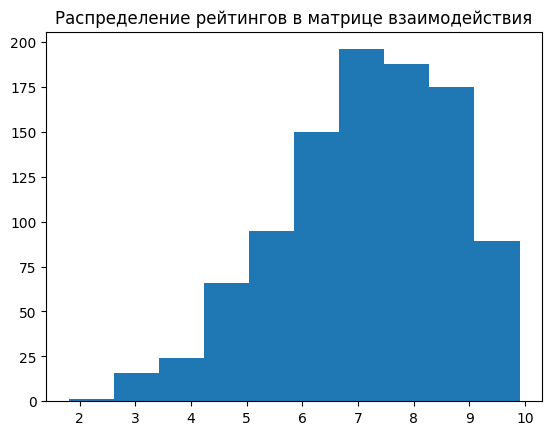

In [4]:
import matplotlib.pyplot as plt

# Демонстрация распределения рейтингов
np.random.seed(SEED)
plt.title('Распределение рейтингов в матрице взаимодействия')
plt.hist(sample_dist(1000));

In [5]:
from implicit.evaluation import train_test_split
import scipy as sp


# Матрица взаимодействия
interac_mat = sp.sparse.random(
    num_users, 
    num_items, 
    density=sparsity_coef,
    random_state=SEED, 
    data_rvs=sample_dist, 
    format='csc'    # формат совместимый с индексацией
)

# Деление на тренировочный и тестовый наборы
interac_mat_train, interac_mat_test = train_test_split(
    interac_mat, 
    train_percentage=0.8, 
    random_state=SEED
)

# Унифицированный способ доступа к данным
interactions = {
    TRAIN: interac_mat_train, 
    TEST: interac_mat_test, 
    WHOLE: interac_mat
}

print("Размер обучающего набора данных:", interactions[TRAIN].shape)
print("Размер тестового набора данных:", interactions[TEST].shape)

/usr/local/lib/python3.10/dist-packages/implicit/gpu/__init__.py:13: UserWarning: CUDA extension is built, but disabling GPU support because of 'Cuda Error: CUDA driver version is insufficient for CUDA runtime version (/project/./implicit/gpu/utils.h:71)'
  warnings.warn(


Размер обучающего набора данных: (10000, 1000)
Размер тестового набора данных: (10000, 1000)


# Обучение модели

In [6]:
from implicit.als import AlternatingLeastSquares

# Создание и обучение модели ALS
model = AlternatingLeastSquares(factors=50)
model.fit(interactions[TRAIN])

  0%|          | 0/15 [00:00<?, ?it/s]

In [7]:
# Модель, симулирующая старую, "худшую" модель, для сравнения 
# ее с новой с помощью serendipity
model_old = AlternatingLeastSquares(factors=30)
model_old.fit(interactions[TRAIN])

  0%|          | 0/15 [00:00<?, ?it/s]

# Результаты

### Функция для Рассчета Recall@k

In [8]:
from scipy.sparse import csr_matrix
from implicit.cpu.als import AlternatingLeastSquares as cpu_ALS_cls
from implicit.gpu.als import AlternatingLeastSquares as gpu_ALS_cls
from typing import Union


def recall_at_k(model: Union[cpu_ALS_cls, gpu_ALS_cls], 
           train_interactions: csr_matrix, 
           test_interactions: csr_matrix, 
           threshold: int=0.5, 
           k: int=10) -> float:
    """
    Рассчет recall@k 

    params: 
        model - ALS модель из пакета implicit
        train_interactions - матрица интеракций в csr формате, на которой обучалась модель формы (юзеры, айтемы)
        test_interactions - матрица тестовых интеракций в csr-формате формы (юзеры, айтемы)
        threshold - пороговое значение, с которого рейтинг в матрице будет считаться положительным/отрицательным. 
            Для бинарных значений (1/0) можно поставить порого 0.5 (по умолчанию) 
        k - сколько первых рекоммендаций берем для рассчета метрики
    """
    assert k > 0, "k should be greater than 0"

    included_users_cnt = 0
    recall_sum = 0

    # Для каждого юзера, если у него > k ненулевых значений в тестовой матрице
    for user_id in range(test_interactions.shape[0]):
        # Вектор скоров item'ов для юзера
        user_items = test_interactions.getrow(user_id)[0]

        # Используя threshold сделать значения рейтингов 0/1
        user_items.data = np.where(user_items.data < threshold, 0, 1)

        # Если меньше k положительных тестовых скоров, не учитываем юзера
        if user_items.count_nonzero() < k:
            continue
        included_users_cnt += 1

        # Получить матрицу top k предсказаний для юзера
        user_preds = model.recommend(
            user_id,
            train_interactions.getrow(user_id), 
            N=k, 
            filter_already_liked_items=True  # автоматически убираем из предсказаний известные значения
        )[0]

        # recall для одного юзера: 
        # (сколько из top k предсказаний имеют значение 1 в train матрице) / (общее кол-во 1 в train для юзера)
        user_recall = np.sum(np.isin(user_items.nonzero(), user_preds)) / user_items.count_nonzero()
        recall_sum += user_recall


    try:
        # Усреднить по всем юзерам
        return recall_sum / included_users_cnt
    except ZeroDivisionError:
        raise Exception("Couldn't calculate recall even for single user, try setting a lower k")



### Функция для рассчета Serendipity@k

In [9]:
def serendipity_at_k(model_new: Union[cpu_ALS_cls, gpu_ALS_cls],
                     model_old: Union[cpu_ALS_cls, gpu_ALS_cls],
                     train_interactions: csr_matrix,
                     k: int=10) -> float:
    serendipity = 0
    """
    Рассчет Serendipity@k

    Метрика Serendipity не определена однозначно. Эта реализаци отдает 
    предпочтение моделям, предсказания которых
        а) Unexpected, потому что раньше модель не рекомендовала предложенные айтемы
        б) Relevant, потому что юзер еще не взаимодействовал с предложенными айтемомами

    params:
        model_new - модель, новизну предсказаний которой мы хотим оценить
        model_old - старая модель, относительно которой сравниваем новую
        train_interactions - интеракции, на которых обучались обе модели
        k - сколько первых рекоммендаций берем для рассчета метрики
    """

    # Для каждого юзера
    for user_id in range(train_interactions.shape[0]):
        # Берем top k предсказаний старой модели. Считаем, что она обучалась на тех же
        # данных, что и новая
        preds_old = model_old.recommend(
            user_id,
            train_interactions.getrow(user_id), 
            N=k, 
            filter_already_liked_items=False  # оставляем тренировочные интеракции для лценки релевантности
        )[0]

        # Берем top k предскаазний новой модели. 
        preds_new = model_new.recommend(
            user_id,
            train_interactions.getrow(user_id), 
            N=k, 
            filter_already_liked_items=False  # оставляем тренировочные интеракции для лценки релевантности
        )[0]

        # Если айтем а) Unexpected, т.е. не был в top k предсказаний старой модели
        # б) Relevant, т.e. его не было в тренировочном наборе, 
        # То увеличиваем счетчик подоходящих айтемов для юзера
        suitable_items_cnt = 0

        suitable_items_cnt = np.sum(
            ~np.isin(preds_new, preds_old) & \
            ~np.isin(preds_new, train_interactions[user_id].indices))

        # Насколько хорошее предсказание - процент подходящих айтемов от k
        serendipity +=  suitable_items_cnt / k

    # Усредняем по юзерам
    serendipity /= train_interactions.shape[0]

    return serendipity


## **Сводная таблица результатов**

In [10]:
from implicit.evaluation import precision_at_k, ndcg_at_k

# Вычисление метрик для обученной модели
precision = precision_at_k(model, interactions[TRAIN], interactions[TEST], K=10)
recall = recall_at_k(model, interactions[TRAIN], interactions[TEST], threshold=7, k=10)
ndcg = ndcg_at_k(model, interactions[TRAIN], interactions[TEST], K=10)
serendipity = serendipity_at_k(model, model_old, interactions[TRAIN], 10)

  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

In [11]:
# Вывод результатов в табличку

import pandas as pd

data = {
    'Метрика': ['Precision@10', 'Recall@10', 'NDCG@10', 'Serendipity@10'],
    'Обученная модель': [precision, recall, ndcg, serendipity],
}

df = pd.DataFrame(data)
print(df)

          Метрика  Обученная модель
0    Precision@10          0.022157
1       Recall@10          0.017141
2         NDCG@10          0.022117
3  Serendipity@10          0.688990


In [17]:
from typing import List


# Функция для вывода рекомендаций пользователя
def get_user_recommendations(user_id: int, 
                             n: int, 
                             interaction_matrix: csr_matrix) -> List[int]:
                             
    # Создание матрицы user_items для указанного пользователя
    user_items = interaction_matrix[user_id]
    
    # Получение рекомендаций для пользователя в порядке убыванич скора
    recommendations = model.recommend(
        user_id,
        user_items.tocsr(),
        N=n, 
        filter_already_liked_items=True)[0].tolist()

    return recommendations

In [18]:
get_user_recommendations(3, 10, interac_mat)

[709, 972, 510, 870, 428, 429, 491, 142, 297, 713]

# Сохранение артефактов модели

In [14]:
import pickle

# Сохранение модели
with open('trained_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Сохранение матрицы взаимодействий
with open('interact_matrix.pkl', 'wb') as f:
    pickle.dump(interac_mat, f)